In [ ]:
# Copyright 2025 Claudio Giovannoni, Carlo Metta, Anna Monreale,
# Salvatore Rinzivillo, Andrea Berti, Sara Colantonio, and
# Francesca Pratesi
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Explanation Module

In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import os
import cv2
from google.colab import drive
drive.mount('/content/drive')
import shutil
import matplotlib.pyplot as plt
import sys
from collections import Counter
import re
sys.path.append('/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/')
import crop_data_utils
import model_training_utils
import array_creation_stacking_utils as acsu
#from crop_data_utils import parse_image_filename

Mounted at /content/drive


In [32]:
def parse_image_filename(filename, class_label=True):
    if class_label:
        parts = filename.split('_')
        patient_id = parts[0]
        study_id = parts[1]
        image_type = parts[3]
        class_label = int(re.search(r'class(\d+)', parts[-1]).group(1))
        slice_index = int(re.search(rf'{image_type}(\d+)', filename).group(1))
        return patient_id, study_id, image_type, class_label, slice_index
    else:
        filename = filename.split('.')[0]
        parts = filename.split('_')
        patient_id = parts[0]
        study_id = parts[1]
        image_type = parts[-1]
        slice_index = int(parts[2][3:])
        return patient_id, study_id, image_type, slice_index


def parse_image_filename2(filename,fullpath=False):
    if fullpath:
        filename = filename.split('/')[-1]
    parts = filename.split('_')
    patient_id = parts[0]
    study_id = parts[1]
    image_type = parts[3]
    class_label = int(re.search(r'class(\d+)', parts[-1]).group(1))
    slice_index = int(re.search(rf'{image_type}(\d+)', filename).group(1))

    return patient_id, study_id, image_type, class_label, slice_index


def custom_preprocessing(image):
    image = np.uint16(image * 255.0)
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(4, 4))
    image = clahe.apply(image) + 30

    return image


def create_imagepairs_dict(path: str):
    image_pairs = {}
    for root, dirs, files in os.walk(path):
        for img_path in files:
            img_name = os.path.basename(img_path)
            patient_id, study_id, image_type, label, slice_index = parse_image_filename2(img_name)
            key = (patient_id, slice_index)
            image_pairs.setdefault(key, {})[image_type] = os.path.join(root,img_path)
            image_pairs[key]['label'] = label

    return image_pairs


def imagepairs_dict_create(path: str):
    '''
    Create a dictionary object with image pairs (key,label):image_type
    Used for stacking the correct images together in the array_stacking function
    '''
    image_pairs = {}
    for root, dirs, files in os.walk(path):
        for img_path in files:
            img_name = os.path.basename(img_path)
            patient_id, study_id, image_type, label, slice_index = parse_image_filename(img_name,
                                                                                        class_label=True)
            key = (patient_id, slice_index)
            image_pairs.setdefault(key, {})[image_type] = os.path.join(root,
                                                                       img_path)
            image_pairs[key]['label'] = label

    return image_pairs


'''
def custom_array_stacking(folder_path: str, preprocessing:bool, target_id: str, tab_mapping_dict_filepath=None):
    stacked_arrays = []
    labels = []
    image_pairs = create_imagepairs_dict(folder_path)
    # Pair and stack images
    for key, image_data in image_pairs.items():
        patient_id, slice_index = key
        if 't2w' in image_data and 'adc' in image_data and 'hbv' in image_data:
            if patient_id == target_id:
                t2w_path = image_data['t2w']
                adc_path = image_data['adc']
                hbv_path = image_data['hbv']
                label = image_data['label']
                if preprocessing:
                    t2w_array = np.array(custom_preprocessing(cv2.imread(t2w_path, cv2.IMREAD_GRAYSCALE)))
                    adc_array = np.array(custom_preprocessing(cv2.imread(adc_path, cv2.IMREAD_GRAYSCALE)))
                    hbv_array = np.array(custom_preprocessing(cv2.imread(hbv_path, cv2.IMREAD_GRAYSCALE)))
                else:
                    t2w_array = np.array(cv2.imread(t2w_path, cv2.IMREAD_GRAYSCALE))
                    adc_array = np.array(cv2.imread(adc_path, cv2.IMREAD_GRAYSCALE))
                    hbv_array = np.array(cv2.imread(hbv_path, cv2.IMREAD_GRAYSCALE))

                t2w_array = np.expand_dims(t2w_array, axis=-1)
                adc_array = np.expand_dims(adc_array, axis=-1)
                hbv_array = np.expand_dims(hbv_array, axis=-1)
                stacked_arrays.append(np.concatenate([t2w_array, adc_array, hbv_array], axis=-1))
                labels.append(label)

    return np.array(stacked_arrays), np.array(labels)
    '''


def custom_array_stacking(folder_path: str,mapping_dict_filepath: str,subset: str):
    stacked_arrays = []
    labels = []
    lost_counter = 0
    image_pairs = imagepairs_dict_create(folder_path)

    # Pair and stack images
    for key, image_data in image_pairs.items():
        patient_id, slice_index = key
        if 't2w' in image_data and 'adc' in image_data and 'hbv' in image_data:
            # check if patient is in mapping dictionary
            t2w_path = image_data['t2w']
            adc_path = image_data['adc']
            hbv_path = image_data['hbv']
            label = image_data['label']

            # Load and preprocess the images as grayscale
            t2w_img = cv2.resize(cv2.imread(t2w_path, cv2.IMREAD_GRAYSCALE), (224,224),interpolation=cv2.INTER_LANCZOS4)
            adc_img = cv2.resize(cv2.imread(adc_path, cv2.IMREAD_GRAYSCALE), (224,224),interpolation=cv2.INTER_LANCZOS4)
            hbv_img = cv2.resize(cv2.imread(hbv_path, cv2.IMREAD_GRAYSCALE), (224,224),interpolation=cv2.INTER_LANCZOS4)

            t2w_array = np.array(t2w_img)
            adc_array = np.array(adc_img)
            hbv_array = np.array(hbv_img)

            # possibility to apply data augmentation on training images
            if subset == 'train':
                t2w_array = np.expand_dims((t2w_array), axis=-1)
                adc_array = np.expand_dims((adc_array), axis=-1)
                hbv_array = np.expand_dims((hbv_array), axis=-1)
                stacked_arrays.append(np.concatenate([t2w_array, adc_array,hbv_array], axis=-1))
                labels.append(label)
            else:
                t2w_array = np.expand_dims(t2w_array, axis=-1)
                adc_array = np.expand_dims(adc_array, axis=-1)
                hbv_array = np.expand_dims(hbv_array, axis=-1)
                stacked_arrays.append(np.concatenate([t2w_array, adc_array,hbv_array], axis=-1))
                labels.append(label)
        else:
            lost_counter += 1
            print(f"{patient_id} not found in mapping dict for subset: {subset}")
    print(f"total lost files:{lost_counter}")
    return np.array(stacked_arrays), np.array(labels)


def array_stacking_check(folder_path: str,target_array, preprocessing:bool, tab_mapping_dict_filepath=None):
    stacked_arrays = []
    labels = []
    image_pairs = create_imagepairs_dict(folder_path)
    target_patient_id = None
    target_slice_index = None
    # Pair and stack images
    for key, image_data in image_pairs.items():
        patient_id, slice_index = key
        if 't2w' in image_data and 'adc' in image_data and 'hbv' in image_data:
            t2w_path = image_data['t2w']
            adc_path = image_data['adc']
            hbv_path = image_data['hbv']
            label = image_data['label']
            if preprocessing:
                t2w_array = np.expand_dims(np.array(custom_preprocessing(cv2.imread(t2w_path, cv2.IMREAD_GRAYSCALE))),axis=-1)
                adc_array = np.expand_dims(np.array(custom_preprocessing(cv2.imread(adc_path, cv2.IMREAD_GRAYSCALE))),axis=-1)
                hbv_array = np.expand_dims(np.array(custom_preprocessing(cv2.imread(hbv_path, cv2.IMREAD_GRAYSCALE))),axis=-1)
            else:
                t2w_array = np.expand_dims(np.array(cv2.imread(t2w_path, cv2.IMREAD_GRAYSCALE)),axis=-1)
                adc_array = np.expand_dims(np.array(cv2.imread(adc_path, cv2.IMREAD_GRAYSCALE)),axis=-1)
                hbv_array = np.expand_dims(np.array(cv2.imread(hbv_path, cv2.IMREAD_GRAYSCALE)),axis=-1)

            # Check if the current array matches the target array
            current_array = np.concatenate([t2w_array, adc_array, hbv_array], axis=-1)
            if np.array_equal(current_array, target_array):
                target_patient_id = patient_id
                target_slice_index = slice_index

    if target_patient_id and target_slice_index:
        # print(target_patient_id, target_slice_index)
        return target_patient_id, target_slice_index

def create_stack(image_path: str, size: tuple):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (224,224),interpolation=cv2.INTER_LANCZOS4)
    img_expanded = np.expand_dims(img_resized,axis=-1)
    return np.array(img_expanded)

def array_stacking_check224(folder_path: str,target_array):
    stacked_arrays = []
    labels = []
    image_pairs = imagepairs_dict_create(folder_path)
    target_patient_id = None
    target_slice_index = None

    # Pair and stack images
    for key, image_data in image_pairs.items():
        patient_id, slice_index = key
        if 't2w' in image_data and 'adc' in image_data and 'hbv' in image_data:
            # check if patient is in mapping dictionary
            t2w_path = image_data['t2w']
            adc_path = image_data['adc']
            hbv_path = image_data['hbv']
            label = image_data['label']

            # Load and preprocess the images as grayscale
            # t2w_img = np.expand_dims(cv2.resize(cv2.imread(t2w_path, cv2.IMREAD_GRAYSCALE), (224,224),interpolation=cv2.INTER_LANCZOS4),axis=-1)
            # adc_img = np.expand_dims(cv2.resize(cv2.imread(adc_path, cv2.IMREAD_GRAYSCALE), (224,224),interpolation=cv2.INTER_LANCZOS4),axis=-1)
            # hbv_img = np.expand_dims(cv2.resize(cv2.imread(hbv_path, cv2.IMREAD_GRAYSCALE), (224,224),interpolation=cv2.INTER_LANCZOS4),axis=-1)

            # t2w_array = np.array(t2w_img)
            # adc_array = np.array(adc_img)
            # hbv_array = np.array(hbv_img)

            t2w_array = create_stack(t2w_path, size=(224,224))
            adc_array = create_stack(adc_path, size=(224,224))
            hbv_array = create_stack(hbv_path, size=(224,224))

            # Check if the current array matches the target array
            current_array = np.concatenate([t2w_array, adc_array, hbv_array], axis=-1)

            if np.array_equal(current_array, target_array):
                target_patient_id = patient_id
                target_slice_index = slice_index

    if target_patient_id and target_slice_index:
        # print(target_patient_id, target_slice_index)
        return target_patient_id, target_slice_index

In [6]:
valid_folder = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/valid/1'
test_folder = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/test/1'
train_folder = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/train/1'

In [33]:
print(array_stacking_check224(valid_folder, target_array=X_valid_2[-1]))

('11299', 17)


In [ ]:
path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/224x224/X_valid.npy'
X_valid_2 = np.load(path)
for x in range(len(X_valid_2)-1,0,-1):
    print(array_stacking_check224(valid_folder, target_array=X_valid_2[x]))

In [41]:
def create_mapping_text_file(array, output_file, index):
    with open(output_file, 'a') as f:
            f.write(f"Index: {index}, Patient_id: {patient_name}, Slice: {slice_index}\n")


valid_folder = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/valid/1'
path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/224x224/X_valid.npy'
output_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/validation_mapping_class1.txt'
X_valid = np.load(path)

# Creating the mapping text file
with open(output_file, 'w') as f:
    for i in range(len(X_valid)):
        target_array = X_valid[i]
        result = (array_stacking_check224(valid_folder, target_array=X_valid_2[i]))
        if result is not None:
            patient_name, slice_index = result
            create_mapping_text_file([(patient_name, slice_index)], output_file, i)
            print(patient_name, slice_index)

10118 11
11231 9
10209 10
11231 12
11080 13
10726 7
11179 12
10883 15
10953 11
11152 15
10100 9
11037 8
11274 12
10584 12
10408 7
10549 12
11274 10
10079 9
11037 9
10110 9
10481 8
10426 11
10209 11
10584 14
10638 13
11239 11
10883 11
10565 8
10549 11
10040 9
10638 11
10781 10
11239 14
11037 10
10329 9
10329 10
10079 11
10707 10
10481 6
10965 15
10329 11
11194 13
10707 13
11149 9
11137 13
11299 15
10549 14
11149 8
11133 8
10875 10
10726 8
11168 7
11299 19
10408 11
10679 11
10707 11
10040 8
10707 9
10118 8
11080 9
10638 12
10110 10
11179 11
10481 7
10953 7
11194 11
10110 11
10079 8
10040 12
10565 7
10781 12
10079 12
10168 10
11231 13
10426 10
10679 12
11133 10
11133 9
10100 12
11299 18
11137 12
10584 11
10875 8
11168 8
10638 9
10584 13
10402 11
10726 10
10679 9
11133 7
11152 13
11152 12
11080 11
10875 11
11299 16
11231 11
11239 15
11179 9
11194 12
10965 13
11472 8
11080 12
10549 10
10953 9
10329 8
10565 11
10402 12
10424 7
11181 12
10424 10
11149 10
11149 11
10168 8
10549 13
10707 12
102

In [ ]:
path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/X_valid.npy'

X_valid_2 = np.load(path)

for target_array in X_valid_2:
    array_stacking_check(valid_folder, target_array,preprocessing=True)
    array_stacking_check(test_folder, target_array,preprocessing=True)
    #array_stacking_check(train_folder, target_array,preprocessing=True)

In [ ]:
file_path = '/content/drive/MyDrive/ABELE_prostate/claudio/X_valid.npy'

X_valid_2 = np.load(file_path)

target_img = X_valid_2[-1][:,:,0]

path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prostate_centered'
for folder in os.listdir(path):
    folder_path = os.path.join(path,folder)
    for patient_path in os.listdir(folder_path):
        image_full_filepath = os.path.join(folder_path,patient_path)
        image = np.array(cv2.imread(image_full_filepath, cv2.IMREAD_GRAYSCALE))
        if np.array_equal(image,target_img):
                print('yay!')
                print(patient_path)

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/ABELE_prostate/claudio/X_valid.npy'
X_valid_2 = np.load(path)

target_img = X_valid_2[-1][:,:,0]

target_img

array([[45341, 45341, 45085, ..., 43037, 45085, 43549],
       [46621, 44317, 47389, ..., 43549, 42525, 43549],
       [45341, 48157, 48925, ..., 42269, 42269, 44573],
       ...,
       [31262, 38941, 38429, ..., 28958, 17950, 20254],
       [33309, 29726, 38429, ..., 21022, 22814, 21790],
       [40989, 26910, 42013, ..., 25374, 15646, 19486]], dtype=uint16)

In [ ]:
path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/X_valid.npy'
array_prova = np.load(path)
array_prova = array_prova[-2]

In [ ]:
valid_folder = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/valid/1'

# Load and stack images for train, valid, and test sets
X_valid, y_valid = array_stacking(valid_folder, subset='valid')

# Count the occurrences of each label
label_counts_valid = Counter(y_valid)

print("Shape of X_valid:", X_valid.shape)

# Print the label distribution for validation set
print("\nValidation set:")
for label, count in label_counts_valid.items():
    print(f"Label {label}: {count} samples")

begin
yay!
11168 not found in mapping dict for subset: valid
11168 not found in mapping dict for subset: valid
total lost files:2
Shape of X_valid: (1, 64, 64, 3)

Validation set:
Label 1: 1 samples


array([[[127, 119,  86],
        [126, 128,  77],
        [124, 149,  67],
        ...,
        [124, 247,  11],
        [127, 244,  11],
        [131, 243,  11]],

       [[128, 114,  83],
        [125, 126,  69],
        [122, 146,  61],
        ...,
        [122, 246,  11],
        [126, 244,  11],
        [132, 243,  11]],

       [[126, 115,  77],
        [124, 125,  70],
        [124, 148,  61],
        ...,
        [118, 246,  11],
        [125, 245,  11],
        [136, 245,  11]],

       ...,

       [[121, 111,  47],
        [128, 119,  25],
        [126, 100,  28],
        ...,
        [ 84, 188,  27],
        [104, 141,  52],
        [130, 113,  69]],

       [[122, 123,  38],
        [130, 129,  24],
        [130, 114,  26],
        ...,
        [ 75, 178,  32],
        [ 91, 127,  58],
        [127,  96,  77]],

       [[112, 134,  31],
        [126, 139,  25],
        [127, 128,  24],
        ...,
        [ 63, 167,  41],
        [ 82, 113,  66],
        [108,  78,  84]]], dtype=uint8)
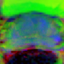

In [ ]:
X_valid[0]

In [ ]:
img_path = '/content/gdrive/My Drive/ABELE_prostate/PICAI_original/csPCa_lesion_delineations/AI/Bosma22a/10168_1000171.nii'

img = nib.load(img_path)
img_fdata = img.get_fdata()
img_shape = img_fdata.shape
img_header = img.header

img_slice = img_fdata[:, :, 12]

plt.imshow(img_slice, cmap='gray')
plt.axis('off')
save_path = '/content/gdrive/My Drive/ABELE_prostate/claudio/black_box/images/10168_1000171_slice_12.png'
plt.savefig(save_path, format='png')
plt.show()

## lesion retrieval

In [ ]:
def create_imagepairs_dict2(path: str):
    image_pairs = {}
    for root, dirs, files in os.walk(path):
        for img_path in files:
            img_name = os.path.basename(img_path)
            patient_id, study_id, image_type, label, slice_index = parse_image_filename2(img_name)
            patient_full_id = f'{patient_id}_{study_id}'
            key = (patient_full_id, slice_index)
            image_pairs.setdefault(key, {})[image_type] = os.path.join(root,img_path)
            image_pairs[key]['label'] = label
    return image_pairs


def array_stacking_check2(folder_path: str,target_array, preprocessing:bool, tab_mapping_dict_filepath=None):
    stacked_arrays = []
    labels = []
    image_pairs = create_imagepairs_dict2(folder_path)
    target_patient_id = None
    target_slice_index = None
    # Pair and stack images
    for key, image_data in image_pairs.items():
        patient_id, slice_index = key
        if 't2w' in image_data and 'adc' in image_data and 'hbv' in image_data:
            t2w_path = image_data['t2w']
            adc_path = image_data['adc']
            hbv_path = image_data['hbv']
            label = image_data['label']
            if preprocessing:
                t2w_array = np.expand_dims(np.array(custom_preprocessing(cv2.imread(t2w_path, cv2.IMREAD_GRAYSCALE))),axis=-1)
                adc_array = np.expand_dims(np.array(custom_preprocessing(cv2.imread(adc_path, cv2.IMREAD_GRAYSCALE))),axis=-1)
                hbv_array = np.expand_dims(np.array(custom_preprocessing(cv2.imread(hbv_path, cv2.IMREAD_GRAYSCALE))),axis=-1)
            else:
                t2w_array = np.expand_dims(np.array(cv2.imread(t2w_path, cv2.IMREAD_GRAYSCALE)),axis=-1)
                adc_array = np.expand_dims(np.array(cv2.imread(adc_path, cv2.IMREAD_GRAYSCALE)),axis=-1)
                hbv_array = np.expand_dims(np.array(cv2.imread(hbv_path, cv2.IMREAD_GRAYSCALE)),axis=-1)

            # Check if the current array matches the target array
            current_array = np.concatenate([t2w_array, adc_array, hbv_array], axis=-1)
            if np.array_equal(current_array, target_array):
                target_patient_id = patient_id
                target_slice_index = slice_index
    if target_patient_id and target_slice_index:
        return target_patient_id, target_slice_index


def lesion_img_saver(nifti_input: str, img_output: str, slice_idx: int):
    img = nib.load(nifti_input)
    img_fdata = img.get_fdata()
    img_shape = img_fdata.shape
    img_header = img.header

    img_slice = img_fdata[:, :, slice_idx]
    cumsum = np.sum(np.sum(img_slice))
    if cumsum >= 30:
        plt.imshow(img_slice, cmap='gray')
        plt.axis('off')
        plt.savefig(img_output, format='png')
        #plt.show()

In [ ]:
path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/X_valid.npy'
X_valid_2 = np.load(path)

X_valid_checklist = []
for array in X_valid_2:
    result = array_stacking_check2(valid_folder, target_array=array,preprocessing=True)
    if result:
        target_patient_id,target_slice_index = result
        X_valid_checklist.append((target_patient_id, target_slice_index))

In [ ]:
import pickle
path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/'
with open(os.path.join(path,'X_valid_checklist'),'wb') as fp:
    pickle.dump(X_valid_checklist,fp)

with open(os.path.join(path,'X_valid_checklist'),'rb') as fp:
    X_valid_checklist = pickle.load(fp)

In [ ]:
print(len(X_valid_checklist))

203


203


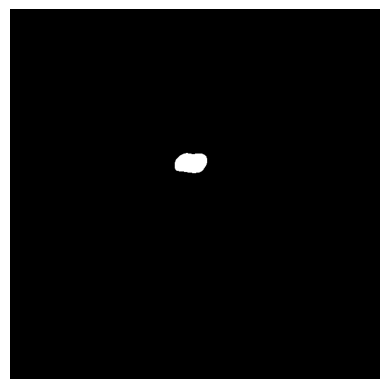

In [ ]:
import nibabel as nib

img_path = '/content/drive/MyDrive/ABELE_prostate/PICAI_original/csPCa_lesion_delineations/AI/Bosma22a/'
save_path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/images/lesion_slices/valid/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

counter = 0
for (patient_id, slice_index) in X_valid_checklist:
    input = os.path.join(img_path,f'{patient_id}.nii')
    output = os.path.join(save_path,f'{patient_id}_slice{slice_index}.png')
    lesion_img_saver(input,output,slice_index)
    counter +=1

In [ ]:
print(len(os.listdir(save_path)))

97


In [ ]:
import pandas as pd

In [ ]:
filepath = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/CSV/dataframes/val/valdf.csv'

valdf = pd.read_csv(filepath)
valdf1 =  valdf[valdf['label'] == 1]
valdf1

,patient_id,image_path,label,modality
0,10965,/content/drive/My Drive/ABELE_prostate/claudio...,1,adc
1,10965,/content/drive/My Drive/ABELE_prostate/claudio...,1,adc
2,10965,/content/drive/My Drive/ABELE_prostate/claudio...,1,adc
3,10965,/content/drive/My Drive/ABELE_prostate/claudio...,1,adc
4,10965,/content/drive/My Drive/ABELE_prostate/claudio...,1,adc
...,...,...,...,...
2105,11149,/content/drive/My Drive/ABELE_prostate/claudio...,1,hbv
2106,11149,/content/drive/My Drive/ABELE_prostate/claudio...,1,hbv
2107,11149,/content/drive/My Drive/ABELE_prostate/claudio...,1,hbv
2108,11149,/content/drive/My Drive/ABELE_prostate/claudio...,1,hbv


In [ ]:
print(valdf1['patient_id'].values)

[10965 10965 10965 10965 10965 10965 10965 10965 10965 10965 10965 10965
 10965 10965 10965 10100 10100 10100 10100 10100 10100 10100 10100 10100
 10100 10100 10100 10100 10100 10100 11274 11274 11274 11274 11274 11274
 11274 11274 11274 11274 11274 11274 11274 11274 11274 10584 10584 10584
 10584 10584 10584 10584 10584 10584 10584 10584 10584 10584 10584 10584
 10875 10875 10875 10875 10875 10875 10875 10875 10875 10875 10875 10875
 10875 10875 10875 10402 10402 10402 10402 10402 10402 10402 10402 10402
 10402 10402 10402 10402 10402 10402 10781 10781 10781 10781 10781 10781
 10781 10781 10781 10781 10781 10781 10781 10781 10781 11133 11133 11133
 11133 11133 11133 11133 11133 11133 11133 11133 11133 11133 11133 11133
 10481 10481 10481 10481 10481 10481 10481 10481 10481 10481 10481 10481
 10481 10481 10481 10079 10079 10079 10079 10079 10079 10079 10079 10079
 10079 10079 10079 10079 10079 10079 11472 11472 11472 11472 11472 11472
 11472 11472 11472 11472 11472 11472 11472 11472 11

In [ ]:
def parse_image_filename3(filename,fullpath=False):
    if fullpath:
        filename = filename.split('/')[-1]
    parts = filename.split('_')
    patient_id = parts[0]
    study_id = parts[1]
    full_id = f"{patient_id}_{study_id}"
    image_type = parts[3].split('.')[0]
    slice_index_match = re.search(rf'{image_type}(\d+)', filename)
    slice_index = int(slice_index_match.group(1))

    return patient_id, study_id, full_id, image_type, slice_index

img = '/content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prostate_centered/10965/10965_1000984_adc11_adc.png'
_, _, full_id,_, idx = parse_image_filename3(img,fullpath=True)
print(full_id)

10965_1000984


11194_1001217_slice9_label1.png
10726_1000742_slice7_label1.png
10209_1000213_slice7_label1.png
10781_1000797_slice10_label1.png
10329_1000335_slice8_label1.png
11152_1001175_slice12_label1.png
11179_1001202_slice8_label1.png
11037_1001057_slice7_label1.png
11274_1001297_slice8_label1.png
10110_1000110_slice8_label1.png
10463_1000471_slice11_label1.png
11239_1001262_slice13_label1.png
10100_1000100_slice8_label1.png
10883_1000899_slice11_label1.png
10079_1000079_slice8_label1.png
10118_1000118_slice8_label1.png
10481_1000489_slice6_label1.png
10965_1000984_slice11_label1.png
10584_1000598_slice10_label1.png
10424_1000432_slice7_label1.png
10549_1000561_slice10_label1.png
11472_1001496_slice5_label1.png
11231_1001254_slice9_label1.png
10707_1000723_slice9_label1.png
10953_1000972_slice7_label1.png
11080_1001102_slice10_label1.png
11299_1001322_slice15_label1.png
10679_1000695_slice9_label1.png
11137_1001160_slice9_label1.png
11181_1001204_slice10_label1.png
10040_1000040_slice8_label1.p

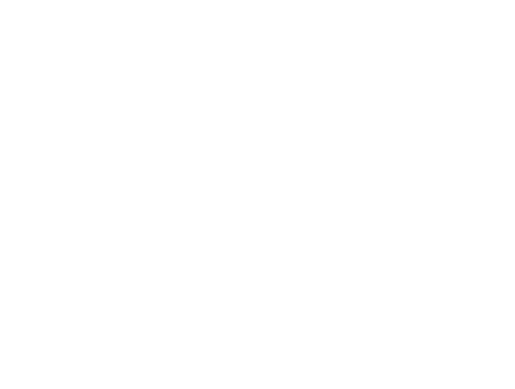

In [ ]:
import nibabel as nib

lesion_path = '/content/drive/MyDrive/ABELE_prostate/PICAI_original/csPCa_lesion_delineations/AI/Bosma22a/'
output_path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/images/lesion_slices/valid/1/'
label = 1

if not os.path.exists(output_path):
    os.makedirs(output_path)

for i,lesion_file in enumerate(os.listdir(lesion_path)):
    #if i > 45:
        #break
    patient_id = lesion_file.split('_')[0]
    # check if patient is in validation dataframe with label 1
    if patient_id in valdf1['patient_id'].astype(str).values:
        # Get the corresponding row in the DataFrame
        patient_row = valdf1[valdf1['patient_id'].astype(str) == patient_id]

        # Apply the parse_image_filename2 function to the 'image_path' value
        parsed_values = parse_image_filename3(patient_row['image_path'].values[0],fullpath=True)
        _, _, full_id,_, idx = parsed_values
        # print(f"full id {full_id} index {idx}")

        # read nibabel file and extract fdata
        full_lesion_path = os.path.join(lesion_path,full_id + '.nii')
        # print(full_lesion_path)
        lesion_img = nib.load(full_lesion_path)
        lesion_img_fdata = lesion_img.get_fdata()

        # get corresponding slice
        lesion_slice = lesion_img_fdata[0,0,:]

        # create lesion filename
        lesion_filename = f'{full_id}_slice{idx}_label{label}.png'
        print(lesion_filename)

        # save lesion png image
        save_path = os.path.join(output_path,lesion_filename)
        #print(save_path)
        plt.axis('off')
        plt.savefig(save_path,format='png')
